# FitTransportData.ipynb

This notebook fits data collected using transport assays. The transport assays measure influx as a function of substrate concentration and the experimental analysis below assumes that time is fixed.

# 1. Introduction

Transport assays measure the amount of radioactive substrate transported into a proteoliposome by a protein of interest. The proteoliposomes are briefly immersed in a solution containing this radioactive substrate, then immobilized on a filter, thoroughly washed, and suspended in scintillation fluid overnight. The signal is quantified in a scintillation counter and scales linearly with the amount of radioactive substrate in the tube. We can therefore correlate the strength of this signal with the transporter's ability to import substrate in general.

Several steps are required to analyze these data. First, the scintillation counter must quantify how much radioactive substrate is in the sample. Second, the data must be corrected by negative controls, which are kept at a lower temperature but are otherwise identical: any signal here should only result from  substrate binding the proteoliposome's exterior. Third, a standard curve must establish the concentration of the transporter in the sample. Finally, a standard curve must establish the relationship between the radioactive substrate and the signal observed by the scintillation counter (this changes over time since the substrate decays over time; however, I exclusively used substrates labeled with tritium, which has a half-life of about twelve years). We go over each of these steps in turn.

The first step is to establish the modules required by this script and the files that will be opened.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import linregress
from scipy.optimize import minimize

import pathlib
import os

In [ ]:
mut = "143_236"

path = "."

# Raw data
transport_file = os.path.join( path, "transport_data.txt" )

# Description of the experiment
# Contains info for substrate standard curve
experiment_file = os.path.join( path, "experimental_setup.txt" )

# Standard curve for protein
protein_q_file = os.path.join( path, "protein_conc.csv" )

# 2. Importing transport data

First the data must be important. The scintillation counter's manufacturer, in their infinite wisdom, decided to save their data as RTFs. As a result, the data must be manually copied and pasted to a TXT file. We will then import these data as a dataframe. We are chiefly interested in the two signals obtained, from which we will take the average.

In [ ]:
df = pd.read_csv( transport_file, sep="\s+", header=None,
    skiprows=47, usecols=[ 2, 3 ], names=[ "CPMA", "CPMB" ] )
df[ 'Avg' ] = df.replace(
    '*****', np.NaN ).astype( float ).mean( axis=1 )

Note that the asterisks indicate the signal strength exceeded the upper bound of quantitation.

I decided to include a description of the samples in a separate file (the scintillation counter does not provide this). The contents of this file will likewise be read as a dataframe; we will then concatenate the two.

In [ ]:
df = pd.concat( [ df, pd.read_csv( experiment_file, sep="\t" ) ], axis=1 )
df

,CPMA,CPMB,Avg,Time (min),Conc (micromolar),Temp,pH,Control (uCi)
0,543,470,506.5,2.0,20.0,Cold,5.5,NaN
1,5477,4986,5231.5,2.0,20.0,RT,5.5,NaN
2,4912,4412,4662.0,2.0,20.0,RT,5.5,NaN
3,5564,5134,5349.0,2.0,20.0,RT,5.5,NaN
4,345,300,322.5,2.0,50.0,Cold,5.5,NaN
5,3048,2839,2943.5,2.0,50.0,RT,5.5,NaN
6,4462,4107,4284.5,2.0,50.0,RT,5.5,NaN
7,4477,4108,4292.5,2.0,50.0,RT,5.5,NaN
8,183,141,162.0,2.0,100.0,Cold,5.5,NaN
9,3148,2887,3017.5,2.0,100.0,RT,5.5,NaN


I want to isolate the pH 4.5 data from the pH 7.5 data. The pH 4.5 data will be used for a curve fit. The pH 7.5 data is simply to check pH-dependent decrease.

In [ ]:
df_ph = df[ df[ 'Conc (micromolar)' ] == 1000. ]
df    = df[ df[ 'pH' ] != 7.5 ]
df_ph

,CPMA,CPMB,Avg,Time (min),Conc (micromolar),Temp,pH,Control (uCi)
20,187,151,169.0,2.0,1000.0,Cold,5.5,NaN
21,759,680,719.5,2.0,1000.0,RT,5.5,NaN
22,969,832,900.5,2.0,1000.0,RT,5.5,NaN
23,1159,1025,1092.0,2.0,1000.0,RT,5.5,NaN
24,544,365,454.5,2.0,1000.0,Cold,7.5,NaN
25,140,102,121.0,2.0,1000.0,RT,7.5,NaN
26,122,90,106.0,2.0,1000.0,RT,7.5,NaN
27,115,89,102.0,2.0,1000.0,RT,7.5,NaN


# 3. Standard curves

This gives us a dataframe with all the raw, unprocessed data. Before we can convert these into meaningful transport rates, we first need to get an idea of:
1. How much protein is in each sample, and
2. How radiolabled substrate concentration correlates with signal strength
We will start with the substrate.

## 3.1 Substrate standard curve

I wanted to check if there are any outliers before making a curve.

In [ ]:
df[[ 'Avg', 'Control (uCi)' ]].dropna()

,Avg,Control (uCi)
28,409122.0,0.500000
29,76086.5,0.100000
30,15888.5,0.020000
31,3422.0,0.004000
32,770.0,0.000800
33,195.5,0.000160
34,40.5,0.000032
35,27.5,0.000006


Looks fine, so I proceeded.

Slope     :	 0.0000012228
Intercept :	 0.0008531267
R         :	 0.9998980762
p-value   :	 0.0000000000
Error     :	 0.0000000071


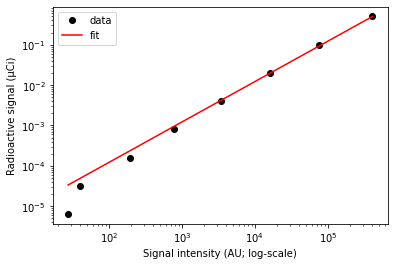

In [ ]:
# Fit
df_s = df[[ 'Avg', 'Control (uCi)' ]].dropna()
fit_s = linregress( df_s[ 'Avg' ], df_s[ 'Control (uCi)' ] )

# Print
linfit_params = [ "Slope", "Intercept", "R", "p-value", "Error" ]
for i, val in enumerate( linfit_params ):
    print( "{:10}:\t{:13.10f}".format( val, fit_s[ i ] ) )
   
# Plot
x_vals = np.linspace(
    np.min( df_s[ 'Avg' ].values ),
    np.max( df_s[ 'Avg' ].values ),
    2
)
plt.loglog(
    df_s[ 'Avg' ],
    df_s[ 'Control (uCi)' ],
    'o',
    color='black',
    label="data"
)
plt.plot(
    x_vals,
    x_vals * fit_s[ 0 ],
    '-r',
    color='red',
    label="fit"
)
plt.legend()
plt.xlabel( "Signal intensity (AU; log-scale)" )
plt.ylabel( "Radioactive signal (µCi)" )
plt.show()

(The plot is double-log to avoid squishing most datapoints into the bottom-left corner)

Now we can make a function to convert the signal into a concentration of substrate. Note that I am not including the negative y-intercept.

In [ ]:
def to_substr( val ): return val * fit_s[ 0 ]

At this point the last few rows of the original dataframe containing the standard curve are no longer relevant to the experiment, so they will be discarded.

In [ ]:
df = df.loc[((df[ 'Temp' ] == "Cold" ) | ( df[ 'Temp' ] == "RT" ))]
df.drop( labels='Control (uCi)', inplace=True, axis=1 )

In [ ]:
df

,CPMA,CPMB,Avg,Time (min),Conc (micromolar),Temp,pH
0,543,470,506.5,2.0,20.0,Cold,5.5
1,5477,4986,5231.5,2.0,20.0,RT,5.5
2,4912,4412,4662.0,2.0,20.0,RT,5.5
3,5564,5134,5349.0,2.0,20.0,RT,5.5
4,345,300,322.5,2.0,50.0,Cold,5.5
5,3048,2839,2943.5,2.0,50.0,RT,5.5
6,4462,4107,4284.5,2.0,50.0,RT,5.5
7,4477,4108,4292.5,2.0,50.0,RT,5.5
8,183,141,162.0,2.0,100.0,Cold,5.5
9,3148,2887,3017.5,2.0,100.0,RT,5.5


## 3.2 Protein standard curve

These measurements come from electrophoresis and densitometry. Known quantities of the transporter protein in detergent are electrophoresed alongside unknown volumes of protein in proteoliposomes (we cannot determine the protein concentration in proteoliposome due to the presence of lipid).

I wanted to see if there are any outliers before making a standard curve:

In [ ]:
protein_q = pd.read_csv( protein_q_file, sep="," )
protein_q

,Protein (ug),Intensity (AU)
0,0.10,197862
1,0.25,139209
2,0.50,246078
3,1.00,430808
4,2.00,528857


Slope     :	 0.0000044148
Intercept :	-0.5922481021
R         :	 0.9461965023
p-value   :	 0.0148598102
Error     :	 0.0000008717


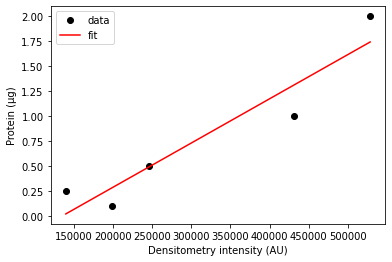

In [ ]:
# Fit
fit_p = linregress( protein_q[ 'Intensity (AU)' ], protein_q[ 'Protein (ug)' ] )

# Print
for i, val in enumerate( linfit_params ):
    print( "{:10}:\t{:13.10f}".format( val, fit_p[ i ] ) )
   
# Plot
x_vals = np.linspace(
    np.min( protein_q[ 'Intensity (AU)' ].values ),
    np.max( protein_q[ 'Intensity (AU)' ].values ),
    2
)

plt.plot( protein_q[ 'Intensity (AU)' ], protein_q[ 'Protein (ug)' ], 'o', color='black', label="data" )
plt.plot( x_vals, x_vals * fit_p[ 0 ] + fit_p[ 1 ], '-r', color='red', label="fit" )
plt.legend()
plt.xlabel( "Densitometry intensity (AU)" )
plt.ylabel( "Protein (µg)" )
plt.show()

At this point we can make a function that converts the densitometry measurement for the protein in proteoliposomes into a mass (in µg). However, since the volume is fixed throughout the experiment, we can just figure out the mass once and use that value for every measurement.

In [ ]:
p_intensity = ( 185465 ) # 2 µL volume
p_per_ul = fit_p[ 0 ] * p_intensity + fit_p[ 1 ]
p_per_exp = p_per_ul
print( "Protein (µg) per µL: {:10f}".format( p_per_exp / 2 ) )

Protein (µg) per µL:   0.113273


## 4. Data formatting

There is a bunch of processing we need to do before we can even fit the data and extract kinetic information. We have measurements in triplicate, but they are spread out over multiple rows. We have negative controls that need to be subtracted from the room-temperature measurements. We have to convert the signal intensity into substrate concentration. And so on.

### 4.1 Determine substrate transport

Now we can start processing the data. Ultimately we want nmol substrate per minute per mg protein. This conversion consists of the following steps:
1. Converting the signal into µCi, the experimental readout.
2. Converting µCi into moles of radiolabeled substrate transported.
3. Converting moles of radiolabeled substrate into moles of total substrate
4. Converting moles of total substrate into nanomoles per minute per mg protein

To make things a bit clearer, we will delete more superfluous rows.

In [ ]:
def calculate_transport( df ):
    # Step 0a: Set constants
    nmol_per_uCi = 1. / 47.9 # Batch-specific. Check the stock.
    vol = 9.8e-5 # in liters (98 microliters)

    # Step 0b: Prepare remaining columns
    #  1e-6: molar per micromolar, 1e9: nmoles per moles
    df[ 'Substrate per rxn (nmol)' ] = \
        df[ 'Conc (micromolar)' ] * 1e-6 * vol * 1e9

    df[ 'Protein per rxn (mg)' ] = \
        p_per_exp / 1000. # currently expressed in micrograms

    df[ 'Proportion labeled substrate' ] = \
        nmol_per_uCi / df[ 'Substrate per rxn (nmol)' ] # 1 uCi per rxn

    # Step 1: Convert signal into uCi
    df[ 'uCi transported' ] = to_substr( df[ 'Avg' ] )

    # Step 2: Convert uCi into moles of radiolabeled substrate
    df[ 'Radiolabeled substrate transported (nmol)' ] = \
        df[ 'uCi transported' ] * nmol_per_uCi

    # Step 3: Calculate total moles of substrate transported
    df[ 'Substrate transported (nmol)' ] = \
        df[ 'Radiolabeled substrate transported (nmol)' ] / \
        df[ 'Proportion labeled substrate' ]

    # Step 4: Calculate transport rate
    df[ 'Transport rate (nmol/min/mg)' ] = \
        df[ 'Substrate transported (nmol)' ] / df[ 'Time (min)' ] / \
        df[ 'Protein per rxn (mg)' ]
    return df

df    = calculate_transport( df )
df_ph = calculate_transport( df_ph )

/Library/Python/3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Library/Python/3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Library/Python/3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [ ]:
df

,CPMA,CPMB,Avg,Time (min),Conc (micromolar),Temp,pH,Substrate per rxn (nmol),Protein per rxn (mg),Proportion labeled substrate,uCi transported,Radiolabeled substrate transported (nmol),Substrate transported (nmol),Transport rate (nmol/min/mg)
0,543,470,506.5,2.0,20.0,Cold,5.5,1.96,0.000227,0.010651,0.000619,0.000013,0.001214,2.679128
1,5477,4986,5231.5,2.0,20.0,RT,5.5,1.96,0.000227,0.010651,0.006397,0.000134,0.012538,27.671984
2,4912,4412,4662.0,2.0,20.0,RT,5.5,1.96,0.000227,0.010651,0.005701,0.000119,0.011173,24.659618
3,5564,5134,5349.0,2.0,20.0,RT,5.5,1.96,0.000227,0.010651,0.006541,0.000137,0.012820,28.293500
4,345,300,322.5,2.0,50.0,Cold,5.5,4.90,0.000227,0.004261,0.000394,0.000008,0.001932,4.264654
5,3048,2839,2943.5,2.0,50.0,RT,5.5,4.90,0.000227,0.004261,0.003599,0.000075,0.017636,38.924059
6,4462,4107,4284.5,2.0,50.0,RT,5.5,4.90,0.000227,0.004261,0.005239,0.000109,0.025671,56.657085
7,4477,4108,4292.5,2.0,50.0,RT,5.5,4.90,0.000227,0.004261,0.005249,0.000110,0.025719,56.762875
8,183,141,162.0,2.0,100.0,Cold,5.5,9.80,0.000227,0.002130,0.000198,0.000004,0.001941,4.284490
9,3148,2887,3017.5,2.0,100.0,RT,5.5,9.80,0.000227,0.002130,0.003690,0.000077,0.036159,79.805230


### 4.2 Baseline correction

We will then subtract the cold, negative control measurement from the room temperature measurement. This can be achieved as follows.

In [ ]:
df[ 'Baseline' ] = 0.0
for conc in df[ 'Conc (micromolar)' ].dropna().unique():
    cold = np.average( [
        df[ ( df[ 'Conc (micromolar)' ] == conc ) & ( df[ 'Temp' ] == "Cold" ) ][ 'Transport rate (nmol/min/mg)' ].values
    ] )
    df.update( df[ df[ 'Conc (micromolar)' ] == conc ].assign( Baseline = cold ) )
df[ "Transport rate (normalized)" ] = df[ "Transport rate (nmol/min/mg)" ] - df[ "Baseline" ]

In [ ]:
df

,CPMA,CPMB,Avg,Time (min),Conc (micromolar),Temp,pH,Substrate per rxn (nmol),Protein per rxn (mg),Proportion labeled substrate,uCi transported,Radiolabeled substrate transported (nmol),Substrate transported (nmol),Transport rate (nmol/min/mg),Baseline,Transport rate (normalized)
0,543.0,470.0,506.5,2.0,20.0,Cold,5.5,1.96,0.000227,0.010651,0.000619,0.000013,0.001214,2.679128,2.679128,0.000000
1,5477.0,4986.0,5231.5,2.0,20.0,RT,5.5,1.96,0.000227,0.010651,0.006397,0.000134,0.012538,27.671984,2.679128,24.992856
2,4912.0,4412.0,4662.0,2.0,20.0,RT,5.5,1.96,0.000227,0.010651,0.005701,0.000119,0.011173,24.659618,2.679128,21.980489
3,5564.0,5134.0,5349.0,2.0,20.0,RT,5.5,1.96,0.000227,0.010651,0.006541,0.000137,0.012820,28.293500,2.679128,25.614371
4,345.0,300.0,322.5,2.0,50.0,Cold,5.5,4.90,0.000227,0.004261,0.000394,0.000008,0.001932,4.264654,4.264654,0.000000
5,3048.0,2839.0,2943.5,2.0,50.0,RT,5.5,4.90,0.000227,0.004261,0.003599,0.000075,0.017636,38.924059,4.264654,34.659405
6,4462.0,4107.0,4284.5,2.0,50.0,RT,5.5,4.90,0.000227,0.004261,0.005239,0.000109,0.025671,56.657085,4.264654,52.392431
7,4477.0,4108.0,4292.5,2.0,50.0,RT,5.5,4.90,0.000227,0.004261,0.005249,0.000110,0.025719,56.762875,4.264654,52.498221
8,183.0,141.0,162.0,2.0,100.0,Cold,5.5,9.80,0.000227,0.002130,0.000198,0.000004,0.001941,4.284490,4.284490,0.000000
9,3148.0,2887.0,3017.5,2.0,100.0,RT,5.5,9.80,0.000227,0.002130,0.003690,0.000077,0.036159,79.805230,4.284490,75.520740


In [ ]:
df_ph[ 'Baseline' ] = 0.0
for conc in df_ph[ 'Conc (micromolar)' ].dropna().unique():
    cold = np.average( [
        df_ph[ ( df_ph[ 'Conc (micromolar)' ] == conc ) & ( df_ph[ 'Temp' ] == "Cold" ) ][ 'Transport rate (nmol/min/mg)' ].values
    ] )
    df_ph.update( df_ph[ df_ph[ 'Conc (micromolar)' ] == conc ].assign( Baseline = cold ) )
df_ph[ "Transport rate (normalized)" ] = df_ph[ "Transport rate (nmol/min/mg)" ] - df_ph[ "Baseline" ]

/Library/Python/3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Python/3.7/site-packages/pandas/core/frame.py:6393: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)
/Library/Python/3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [ ]:
df_ph

,CPMA,CPMB,Avg,Time (min),Conc (micromolar),Temp,pH,Control (uCi),Substrate per rxn (nmol),Protein per rxn (mg),Proportion labeled substrate,uCi transported,Radiolabeled substrate transported (nmol),Substrate transported (nmol),Transport rate (nmol/min/mg),Baseline,Transport rate (normalized)
20,187,151,169.0,2.0,1000.0,Cold,5.5,NaN,98.0,0.000227,0.000213,0.000207,0.000004,0.020251,44.696218,82.449976,-37.753758
21,759,680,719.5,2.0,1000.0,RT,5.5,NaN,98.0,0.000227,0.000213,0.000880,0.000018,0.086219,190.289521,82.449976,107.839544
22,969,832,900.5,2.0,1000.0,RT,5.5,NaN,98.0,0.000227,0.000213,0.001101,0.000023,0.107908,238.159435,82.449976,155.709458
23,1159,1025,1092.0,2.0,1000.0,RT,5.5,NaN,98.0,0.000227,0.000213,0.001335,0.000028,0.130856,288.806333,82.449976,206.356357
24,544,365,454.5,2.0,1000.0,Cold,7.5,NaN,98.0,0.000227,0.000213,0.000556,0.000012,0.054463,120.203735,82.449976,37.753758
25,140,102,121.0,2.0,1000.0,RT,7.5,NaN,98.0,0.000227,0.000213,0.000148,0.000003,0.014500,32.001434,82.449976,-50.448542
26,122,90,106.0,2.0,1000.0,RT,7.5,NaN,98.0,0.000227,0.000213,0.000130,0.000003,0.012702,28.034314,82.449976,-54.415662
27,115,89,102.0,2.0,1000.0,RT,7.5,NaN,98.0,0.000227,0.000213,0.000125,0.000003,0.012223,26.976416,82.449976,-55.473561


### 4.3 Determining substrate transport

Finally we need to plot these results. I'll first generate a preliminary plot with the points to get an idea of the protein's kinetic profile.

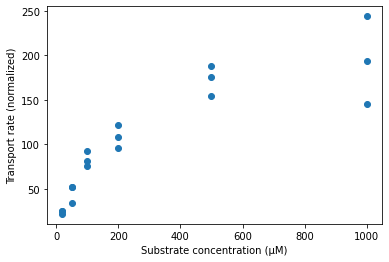

In [ ]:
plt.plot( df[ df[ "Temp" ] == "RT" ][ 'Conc (micromolar)' ], df[ df[ "Temp" ] == "RT" ][ 'Transport rate (normalized)' ], 'o' )
plt.xlabel( 'Substrate concentration (µM)' )
plt.ylabel( 'Transport rate (normalized)' )
plt.show()

## 5. Fitting and visualization

### 5.1 Fitting the data

Looks good. To quantify the kinetics of this protein, we need to fit these data using the Michaelis-Menten formula. I'm going to Scipy's minimize function for fitting. This means defining a parametric model and minimizing the sum-of-squared residuals of the fit to the data.

In [ ]:
def michaelis_menten( v ):
    vmax, km = v[ 0 ], v[ 1 ]
    return np.sum( ( df[ df[ "Temp" ] == "RT" ][ 'Transport rate (normalized)' ] - \
        ( df[ df[ "Temp" ] == "RT" ][ 'Conc (micromolar)' ] * vmax ) / \
        ( df[ df[ "Temp" ] == "RT" ][ 'Conc (micromolar)' ] + km ) ) ** 2. )

In [ ]:
# Initialize parameters for Vmax and Km
params = np.array( [ np.random.uniform( 100., 400. ), np.random.uniform( 100., 600. ) ] )
res = minimize( michaelis_menten, params, method='trust-constr' )
vmax, km = res.x
print( "Vmax: {:8.5f} nmol/min/mg".format( vmax ) )
print( "Km: {:8.5f} µM".format( km ) )

Vmax: 235.09734 nmol/min/mg
Km: 200.62147 µM


### 5.2 Plotting the fit

At this point I would like to plot the fit alongside a more visually pleasing chart. This means averages and error bars (displaying the standard error of the mean). The following function will perform this conversion.

In [ ]:
def plottable( df, x, y ):
    r"""Generate dataframe with an average and standard error instead of raw points

    Parameters:
    df : dataframe with data
    x  : string defining x axis
    y  : string defining y axis

    Returns:
    pandas DataFrame
    """
    y_avg = y + ' (Average)'
    y_sterr = y + ' (St. Error)'
    df_out = pd.DataFrame( columns=[ x, y_avg, y_sterr ] )
    for x_val in df[ x ].unique():
        y_vals = df[ df[ x ] == x_val ][ y ].values
        avg = np.average( y_vals )
        sterr = np.std( y_vals ) / np.sqrt( len( y_vals ) )
        df_out = df_out.append( { x: x_val, y_avg : avg, y_sterr : sterr }, ignore_index=True )
    return df_out

In [ ]:
# Run the function
df_2 = plottable( df[ df[ "Temp" ] == "RT" ], 'Conc (micromolar)', 'Transport rate (normalized)' )
df_2

,Conc (micromolar),Transport rate (normalized) (Average),Transport rate (normalized) (St. Error)
0,20.0,24.195905,0.916227
1,50.0,46.516685,4.840779
2,100.0,83.331559,4.032607
3,200.0,108.822508,5.948248
4,500.0,172.768074,8.237547
5,1000.0,194.388878,23.223710


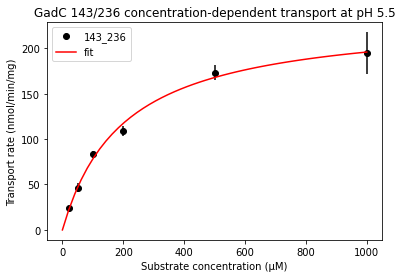

In [ ]:
plt.plot(
    df_2[ 'Conc (micromolar)' ],
    df_2[ 'Transport rate (normalized) (Average)' ],
    'o',
    color="black",
    label=mut )
plt.errorbar(
    df_2[ 'Conc (micromolar)' ],
    df_2[ 'Transport rate (normalized) (Average)' ],
    color="black",
    fmt='none',
    yerr=df_2[ 'Transport rate (normalized) (St. Error)' ] )
x = np.linspace( 0, 1000, 50 )
plt.plot( x, ( x * vmax ) / ( x + km ), color="red", label="fit" )
plt.xlabel( 'Substrate concentration (µM)' )
plt.ylabel( 'Transport rate (nmol/min/mg)' )
plt.title( 'GadC 143/236 concentration-dependent transport at pH 5.5' )
plt.legend( loc="upper left" )
plt.show()

Second piece of data to plot is pH-dependent inactivation. These are both collected at 1 mM.

In [ ]:
df_ph = plottable( df_ph[ df_ph[ "Temp" ] == "RT" ], 'pH', 'Transport rate (normalized)' )

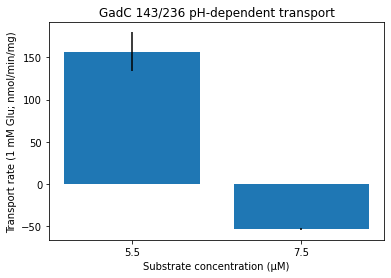

In [ ]:
plt.bar( list( map( str, df_ph[ 'pH' ].values ) ), df_ph[ 'Transport rate (normalized) (Average)' ].values, yerr=df_ph[ 'Transport rate (normalized) (St. Error)' ] )
plt.xlabel( 'Substrate concentration (µM)' )
plt.ylabel( 'Transport rate (1 mM Glu; nmol/min/mg)' )
plt.title( 'GadC 143/236 pH-dependent transport' )
plt.show()

### 5.3 Saving the data

Now it's time to save the formatted datapoints and the fit.

In [ ]:
# Our dataframes
df.to_csv( "_".join( ( mut, "processed_data.csv" ) ), index=False )
df_2.to_csv( "_".join( ( mut, "formatted_data_clean.csv" ) ), index=False )

# The fit
x_arr = np.linspace( 0, 1000, 1000 )
y_arr = ( x_arr * vmax ) / ( x_arr + km )
pd.DataFrame(
    { "Conc (micromolar)": x_arr, "Transport rate (normalized)" : y_arr }
    ).to_csv( "_".join( ( mut, "formatted_fit.csv" ) ), index=False )

In [ ]:
df_ph.to_csv( "ph75.csv", index=False )